# Comparing surrogate models

Tim Head, July 2016.

In [1]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

Bayesian optimization or sequential model-based optimization uses a surrogate model
to model the expensive to evaluate function `func`. There are several choices
for what kind of surrogate model to use. This notebook compares the performance of:

* gaussian processes,
* extra trees, and
* random forests 

as surrogate models. A purely random optimization strategy is also used as a baseline.


# Toy model

We will use the `branin` function as toy model for the expensive function. In
a real world application this function would be unknown and expensive to evaluate.

In [2]:
from skopt.benchmarks import branin as _branin

def branin(x, noise_level=0.):
    return _branin(x) + noise_level * np.random.randn()

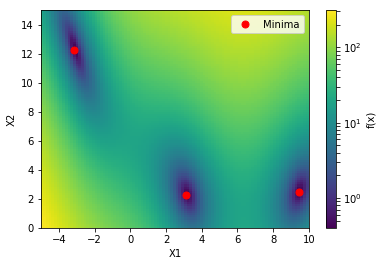

In [3]:
from matplotlib.colors import LogNorm

def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))
    
    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")
    
    ax.legend(loc="best", numpoints=1)
    
    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])
    
plot_branin()

This shows the value of the two-dimensional branin function and the three minima.


# Objective

The objective of this example is to find one of these minima in as few iterations
as possible. One iteration is defined as one call to the `branin` function.

We will evaluate each model several times using a different seed for the
random number generator. Then compare the average performance of these
models. This makes the comparison more robust against models that get
"lucky".

In [4]:
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize

func = partial(branin, noise_level=2.0)
bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 60

In [5]:
def run(minimizer, n_iter=5):
    return [minimizer(func, bounds, n_calls=n_calls, random_state=n) 
            for n in range(n_iter)]

# Random search
dummy_res = run(dummy_minimize) 

# Gaussian processes
gp_res = run(gp_minimize)

# Random forest
rf_res = run(partial(forest_minimize, base_estimator="RF"))

# Extra trees 
et_res = run(partial(forest_minimize, base_estimator="ET"))

Note that this can take a few minutes.

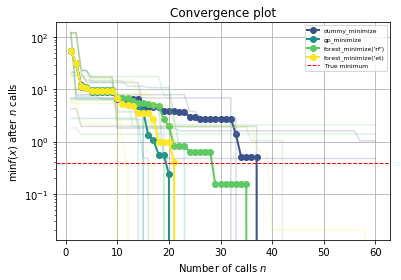

In [6]:
from skopt.plots import plot_convergence

plot = plot_convergence(("dummy_minimize", dummy_res),
                        ("gp_minimize", gp_res),
                        ("forest_minimize('rf')", rf_res),
                        ("forest_minimize('et)", et_res), 
                        true_minimum=0.397887, yscale="log")

plot.legend(loc="best", prop={'size': 6}, numpoints=1);

This plot shows the value of the minimum found (y axis) as a function of the number
of iterations performed so far (x axis). The dashed red line indicates the
true value of the minimum of the branin function.

For the first ten iterations all methods perform equally well as they all start
by creating ten random samples before fitting their respective model for the
first time. After iteration ten the next point at which to evaluate `branin` is
guided by the model, which is where differences start to appear.

Each minimizer only has access to noisy observations of the objective
function, so as time passes (more iterations) it will start observing values that
are below the true value simply because they are fluctuations.